## Model Calibration (Fitting to the Smile)

Calibration is the reverse of pricing.

- **Pricing:** Parameters $\rightarrow$ Price.
    
- **Calibration:** Market Prices $\rightarrow$ Parameters.
    

We use **Least Squares Optimization**. We search for the set of parameters $\Theta = \{v_0, \kappa, \theta, \xi, \rho\}$ that minimizes the difference between our model prices and market prices.

$$\min_{\Theta} \sum_{i=1}^{N} (C_{model}(K_i, T_i) - C_{market}(K_i, T_i))^2$$

The diagram below shows what we are trying to fit: the **Volatility Smile**. If Heston is working, it should capture the "skew" (higher prices for low-strike puts) better than Black-Scholes.

In [3]:
import pandas as pd
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si

## Import .parquet Datasets

In [19]:
from data_loader import MarketDataLoader
from quant_math_engine import heston_call_price, implied_volatility

# Load all massive Parquet files into this notebook's RAM
BASE_DIR = r"G:\My Drive\00) Interview Prep\00) Quant\Data Sources\WRDS Data\Returns\Options"
loader = MarketDataLoader(BASE_DIR)

Loading Options, Spot, Yield, and Dividend Data into memory...
✅ Data Loaded Successfully.


In [21]:
# 1. Explicitly define your scenario variables so the plotter can see them later
TARGET_DATE = '2024-01-10'
TARGET_EXDATE = '2024-02-16'

# 2. Feed them to the loader to get the exact state
state = loader.get_market_state(TARGET_DATE, TARGET_EXDATE, strike_bound_pct=0.10)

# 3. Extract the variables for the optimizer
S0, T, r, q = state['S0'], state['T'], state['r'], state['q']
market_strikes, market_prices = state['strikes'], state['prices']

print(f"✅ Loaded {len(market_strikes)} strikes. S0: {S0}, r: {r*100:.2f}%")

✅ Loaded 352 strikes. S0: 4783.45, r: 5.37%


🌍 Starting PRO-LEVEL Hybrid Calibration for 2024-01-10...
Focusing on 352 highly liquid strikes between 4305 and 5262.

[Stage 1] Global Genetic Search (Finding the valley)...
[Stage 2] L-BFGS-B (Pinpointing the exact minimum)...

✅ PRO Calibration Complete in 1286.05s
🏆 FINAL PARAMETERS
v0    = 0.0115
kappa = 3.0293
theta = 0.0684
xi    = 1.1963
rho   = -0.6572
MSE   = 0.000032
Generating smooth curve...


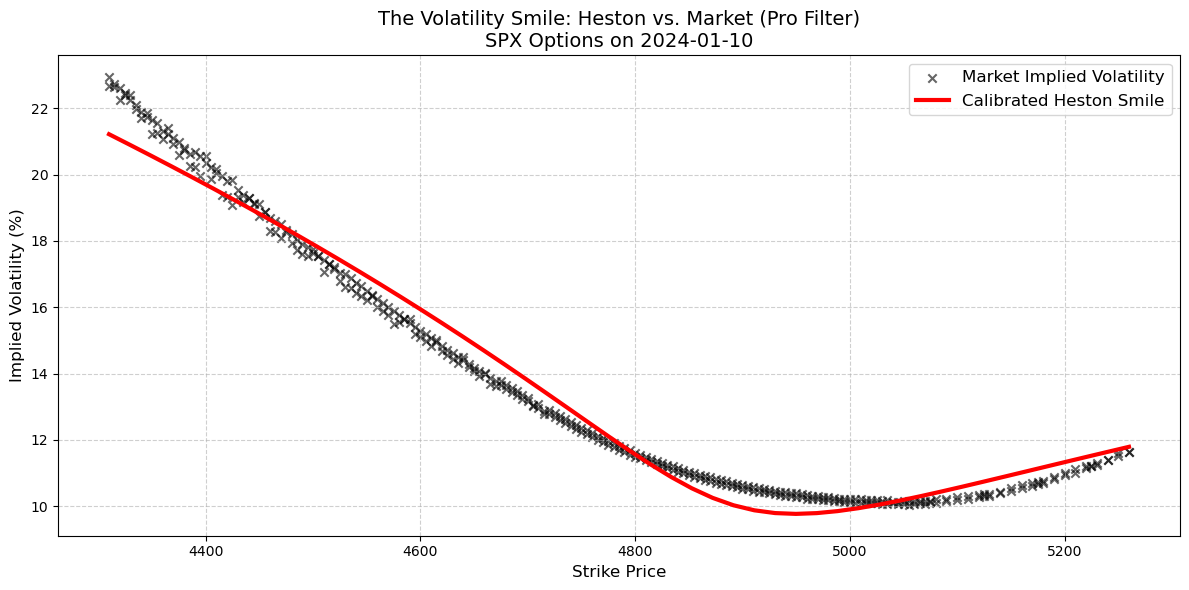

In [14]:
from scipy.optimize import differential_evolution, minimize
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt

print(f"🌍 Starting PRO-LEVEL Hybrid Calibration for {TARGET_DATE}...")

# --- 1. The Pro Fix: Tighten to High-Signal Region (+/- 10%) ---
# This eliminates the extreme OTM noise that causes the integrator to oscillate
lower_bound = S0 * 0.90
upper_bound = S0 * 1.10

# Create masks to filter our arrays
mask = (market_strikes >= lower_bound) & (market_strikes <= upper_bound)
target_strikes = market_strikes[mask]
target_prices = market_prices[mask]

# Calculate IV only for the filtered strikes
target_ivs = []
valid_strikes = []
for i, K in enumerate(target_strikes):
    iv = implied_volatility(target_prices[i], S0, K, T, r, q)
    if not np.isnan(iv):
        target_ivs.append(iv)
        valid_strikes.append(K)

valid_strikes = np.array(valid_strikes)
target_ivs = np.array(target_ivs)

print(f"Focusing on {len(valid_strikes)} highly liquid strikes between {lower_bound:.0f} and {upper_bound:.0f}.")

# --- 2. The Objective Function (Untethered) ---
def pro_objective(params):
    v0, kappa, theta, xi, rho = params
    
    # --- FELLER PENALTY COMPLETELY REMOVED ---
    # We allow the model to violate Feller to capture the extreme SPX equity skew.
        
    error = 0.0
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, K in enumerate(valid_strikes):
            m_price = heston_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho)
            m_iv = implied_volatility(m_price, S0, K, T, r, q)
            
            if np.isnan(m_iv):
                error += 5.0 # Keep the penalty for un-priceable options
            else:
                error += (m_iv - target_ivs[i])**2
                
    return error / len(valid_strikes)

# Bounds derived from academic literature for the S&P 500
pro_bounds = [
    (0.01, 0.15),   # v0 (Starting Var)
    (0.5, 5.0),     # kappa (Mean Reversion)
    (0.01, 0.15),   # theta (Long-term Var)
    (0.05, 1.2),    # xi (Vol of Vol - Restricted to prevent oscillations)
    (-0.95, -0.4)   # rho (Forcing the Negative Equity Skew)
]

start_time = time.time()

# --- STAGE 1: GLOBAL EVOLUTION ---
print("\n[Stage 1] Global Genetic Search (Finding the valley)...")
res_global = differential_evolution(
    pro_objective, 
    pro_bounds, 
    popsize=8,        # Small population for speed 
    maxiter=15,       # Hard cutoff
    init='latinhypercube',
    mutation=(0.5, 1.0),
    recombination=0.7,
    seed=42
)

# --- STAGE 2: LOCAL SHARPENING ---
print("[Stage 2] L-BFGS-B (Pinpointing the exact minimum)...")
res_final = minimize(
    pro_objective,
    res_global.x,
    method='L-BFGS-B',
    bounds=pro_bounds,
    options={'ftol': 1e-7, 'maxiter': 50}
)

elapsed = round(time.time() - start_time, 2)
v0_opt, kappa_opt, theta_opt, xi_opt, rho_opt = res_final.x

print(f"\n✅ PRO Calibration Complete in {elapsed}s")
print("="*40)
print("🏆 FINAL PARAMETERS")
print("="*40)
print(f"v0    = {v0_opt:.4f}")
print(f"kappa = {kappa_opt:.4f}")
print(f"theta = {theta_opt:.4f}")
print(f"xi    = {xi_opt:.4f}")
print(f"rho   = {rho_opt:.4f}")
print(f"MSE   = {res_final.fun:.6f}")
print("="*40)

# --- 3. Plotting the Smooth Result ---
print("Generating smooth curve...")
# Generate 50 perfectly spaced points within our new restricted window
smooth_strikes = np.linspace(min(valid_strikes), max(valid_strikes), 50)

# Suppress warnings during plotting
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_prices = [heston_call_price(S0, k, T, r, q, *res_final.x) for k in smooth_strikes]
    model_iv = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(model_prices, smooth_strikes)]

# Filter out any lingering NaNs just in case
valid_idx = ~np.isnan(model_iv)
clean_strikes = np.array(smooth_strikes)[valid_idx]
clean_iv = np.array(model_iv)[valid_idx] * 100

plt.figure(figsize=(12, 6))
plt.scatter(valid_strikes, target_ivs * 100, color='black', label='Market Implied Volatility', marker='x', alpha=0.6)
plt.plot(clean_strikes, clean_iv, color='red', label='Calibrated Heston Smile', linewidth=3)

plt.title(f"The Volatility Smile: Heston vs. Market (Pro Filter)\nSPX Options on {TARGET_DATE}", fontsize=14)
plt.xlabel("Strike Price", fontsize=12)
plt.ylabel("Implied Volatility (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Calculating Implied Volatilities... (Takes just a moment)


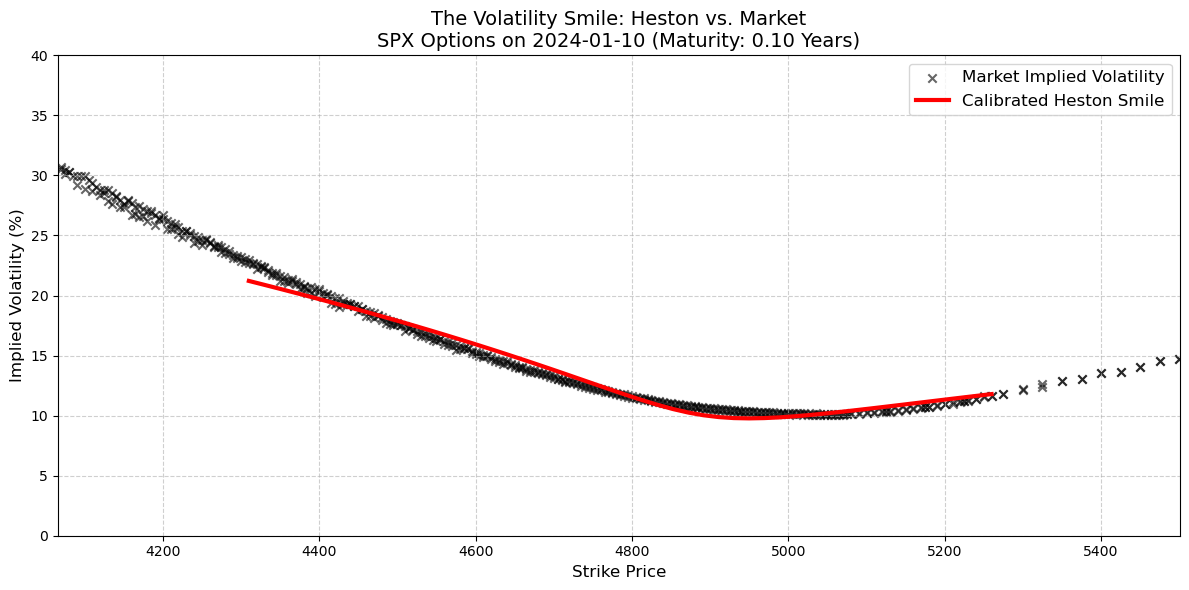

In [15]:
from scipy.optimize import brentq
import warnings

def bs_call_price(sigma, S, K, T, r, q):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)

def implied_volatility(target_price, S, K, T, r, q):
    intrinsic = max(S * np.exp(-q*T) - K * np.exp(-r*T), 0)
    if target_price <= intrinsic: return np.nan 

    def objective(sigma):
        return bs_call_price(sigma, S, K, T, r, q) - target_price

    try:
        return brentq(objective, 1e-4, 5.0) # Widened search bounds slightly
    except ValueError:
        return np.nan

print("Calculating Implied Volatilities... (Takes just a moment)")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    market_iv = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(market_prices, market_strikes)]
    model_iv  = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(model_prices, smooth_strikes)]

# --- THE CLEANUP FIX ---
# Filter out the NaN values so the line connects smoothly
valid_idx = ~np.isnan(model_iv)
clean_strikes = np.array(smooth_strikes)[valid_idx]
clean_iv = np.array(model_iv)[valid_idx] * 100

plt.figure(figsize=(12, 6))

# Plot only the valid Market IVs
plt.scatter(market_strikes, np.array(market_iv) * 100, color='black', label='Market Implied Volatility', marker='x', alpha=0.6)

# Plot the cleaned Heston IV line
plt.plot(clean_strikes, clean_iv, color='red', label='Calibrated Heston Smile', linewidth=3)

plt.title(f"The Volatility Smile: Heston vs. Market\nSPX Options on {TARGET_DATE} (Maturity: {T:.2f} Years)", fontsize=14)
plt.xlabel("Strike Price", fontsize=12)
plt.ylabel("Implied Volatility (%)", fontsize=12)

# Zoom in on the relevant OTM/ATM region to see the true "Smile"
plt.xlim(S0 * 0.85, S0 * 1.15) # Show from 85% to 115% of Spot Price
plt.ylim(0, 40)                # Cap IV at 40% for better visual scaling

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Merton elegantly proved that a Jump Diffusion European Call is simply an **infinite sum of Black-Scholes formulas**, weighted by the probability of $n$ jumps occurring (which follows a Poisson distribution).

$$C_{MJD} = \sum_{n=0}^{\infty} \frac{e^{-\lambda' T} (\lambda' T)^n}{n!} C_{BS}(S_0, K, T, r_n, \sigma_n)$$

Where:

- $k = \exp(\mu_J + \frac{\delta^2}{2}) - 1$ (Expected percentage jump size)
    
- $\lambda' = \lambda (1 + k)$ (Risk-neutral jump intensity)
    
- $\sigma_n^2 = \sigma^2 + \frac{n \delta^2}{T}$ (Adjusted volatility for $n$ jumps)
    
- $r_n = r - \lambda k + \frac{n \ln(1+k)}{T}$ (Adjusted risk-free rate for $n$ jumps)
    

In practice, we don't calculate to infinity. The probability of more than 20 jumps happening in a year is virtually zero, so we sum the first 20 to 50 terms.

In [16]:
import math

def merton_jump_call(S, K, T, r, q, sigma, lam, mu_j, delta, max_jumps=40):
    """
    Calculates the Merton Jump Diffusion European Call Price 
    using the analytical infinite series (truncated).
    """
    # Expected jump size (k)
    k = np.exp(mu_j + 0.5 * delta**2) - 1
    
    # Risk-neutral jump intensity
    lambda_prime = lam * (1 + k)
    
    price = 0.0
    
    # Sum the Poisson-weighted Black-Scholes prices
    for n in range(max_jumps):
        # Probability of exactly n jumps happening
        poisson_weight = np.exp(-lambda_prime * T) * ((lambda_prime * T)**n) / math.factorial(n)
        
        # Adjusted volatility for n jumps
        sigma_n = np.sqrt(sigma**2 + (n * delta**2) / T)
        
        # Adjusted risk-free rate for n jumps
        r_n = r - lam * k + (n * np.log(1 + k)) / T
        
        # Calculate BS price for this specific jump state
        bs_price_n = bs_call_price(sigma_n, S, K, T, r_n, q)
        
        # Add to total price
        price += poisson_weight * bs_price_n
        
    return price

# --- Quick Sanity Check ---
# Compare standard Black-Scholes to Merton with a 20% crash risk
bs_test = bs_call_price(sigma=0.15, S=100, K=90, T=1, r=0.05, q=0)
mjd_test = merton_jump_call(S=100, K=90, T=1, r=0.05, q=0, 
                            sigma=0.15, lam=1.0, mu_j=-0.20, delta=0.10)

print(f"Standard BS Price (OTM Put Equiv):  {bs_test:.2f}")
print(f"Merton Price (With Crash Risk):     {mjd_test:.2f}")

Standard BS Price (OTM Put Equiv):  15.47
Merton Price (With Crash Risk):     18.81


🚀 Starting Merton Jump Diffusion Calibration...
✅ Merton Calibration Complete in 60.99s!
🏆 OPTIMAL MERTON PARAMETERS
sigma = 0.0858 (Baseline Vol)
lam   = 0.9923 (Jumps/Year)
mu_j  = -0.0825 (Avg Jump Size)
delta = 0.0779 (Jump Vol)
MSE   = 0.000005
Generating Master Volatility Smile Plot...


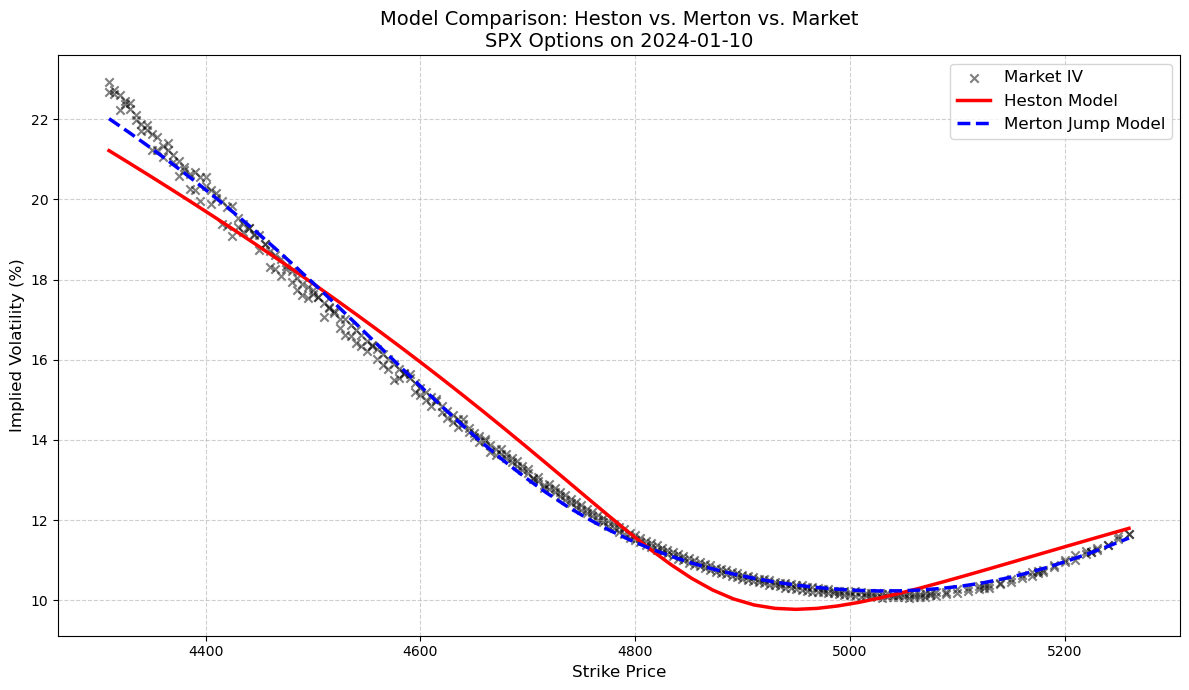

In [17]:
import math
from scipy.optimize import minimize
import time

print("🚀 Starting Merton Jump Diffusion Calibration...")

# --- 1. The Merton Analytical Pricer ---
def merton_jump_call(S, K, T, r, q, sigma, lam, mu_j, delta, max_jumps=40):
    k = np.exp(mu_j + 0.5 * delta**2) - 1
    lambda_prime = lam * (1 + k)
    price = 0.0
    
    for n in range(max_jumps):
        # Poisson probability of exactly 'n' jumps
        poisson_weight = np.exp(-lambda_prime * T) * ((lambda_prime * T)**n) / math.factorial(n)
        
        # Adjust volatility and drift for 'n' jumps
        sigma_n = np.sqrt(sigma**2 + (n * delta**2) / T)
        r_n = r - lam * k + (n * np.log(1 + k)) / T
        
        # Black-Scholes price for this state
        bs_price_n = bs_call_price(sigma_n, S, K, T, r_n, q)
        price += poisson_weight * bs_price_n
        
    return price

# --- 2. The Merton Objective Function ---
def merton_objective(params):
    sigma, lam, mu_j, delta = params
    error = 0.0
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, K in enumerate(valid_strikes):
            m_price = merton_jump_call(S0, K, T, r, q, sigma, lam, mu_j, delta)
            m_iv = implied_volatility(m_price, S0, K, T, r, q)
            
            if np.isnan(m_iv):
                error += 5.0
            else:
                error += (m_iv - target_ivs[i])**2
                
    return error / len(valid_strikes)

# --- 3. Run Fast Local Optimizer ---
# Initial Guess: 15% vol, 1 jump/year, -15% average jump, 10% jump vol
merton_guess = [0.15, 1.0, -0.15, 0.10] 

merton_bounds = [
    (0.05, 0.30),   # sigma (Baseline Volatility)
    (0.1, 5.0),     # lam (Jumps per year)
    (-0.5, 0.0),    # mu_j (Forcing negative jumps to fit the skew)
    (0.01, 0.30)    # delta (Jump Volatility)
]

start_time = time.time()
res_merton = minimize(
    merton_objective,
    merton_guess,
    method='L-BFGS-B',
    bounds=merton_bounds,
    options={'ftol': 1e-7, 'maxiter': 100}
)
elapsed = round(time.time() - start_time, 2)

sigma_opt, lam_opt, mu_j_opt, delta_opt = res_merton.x

print(f"✅ Merton Calibration Complete in {elapsed}s!")
print("="*40)
print("🏆 OPTIMAL MERTON PARAMETERS")
print("="*40)
print(f"sigma = {sigma_opt:.4f} (Baseline Vol)")
print(f"lam   = {lam_opt:.4f} (Jumps/Year)")
print(f"mu_j  = {mu_j_opt:.4f} (Avg Jump Size)")
print(f"delta = {delta_opt:.4f} (Jump Vol)")
print(f"MSE   = {res_merton.fun:.6f}")
print("="*40)

# --- 4. The Master Plot: Market vs Heston vs Merton ---
print("Generating Master Volatility Smile Plot...")

# Calculate Merton IVs for the smooth curve
merton_prices = [merton_jump_call(S0, k, T, r, q, *res_merton.x) for k in smooth_strikes]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    merton_iv = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(merton_prices, smooth_strikes)]

# Clean arrays for plotting
valid_idx_m = ~np.isnan(merton_iv)
clean_strikes_m = np.array(smooth_strikes)[valid_idx_m]
clean_iv_m = np.array(merton_iv)[valid_idx_m] * 100

plt.figure(figsize=(12, 7))

# Plot Market
plt.scatter(valid_strikes, target_ivs * 100, color='black', label='Market IV', marker='x', alpha=0.5)

# Plot Heston (Using the clean arrays we generated at the end of the previous step)
plt.plot(clean_strikes, clean_iv, color='red', label=f'Heston Model', linewidth=2.5)

# Plot Merton
plt.plot(clean_strikes_m, clean_iv_m, color='blue', label=f'Merton Jump Model', linewidth=2.5, linestyle='--')

plt.title(f"Model Comparison: Heston vs. Merton vs. Market\nSPX Options on {TARGET_DATE}", fontsize=14)
plt.xlabel("Strike Price", fontsize=12)
plt.ylabel("Implied Volatility (%)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

🚀 Starting Final Bates (SVJ) Calibration...
✅ Bates Calibration Complete in 387.25s!
🏆 OPTIMAL BATES (SVJ) PARAMETERS
v0    = 0.0135 | kappa = 3.0290 | theta = 0.0538
xi    = 1.1915 | rho   = -0.6470
lam   = 0.9869 | mu_j  = 0.0000 | delta = 0.0148
Final IV Error (MSE): 0.000031
Generating the Ultimate Volatility Smile Plot...


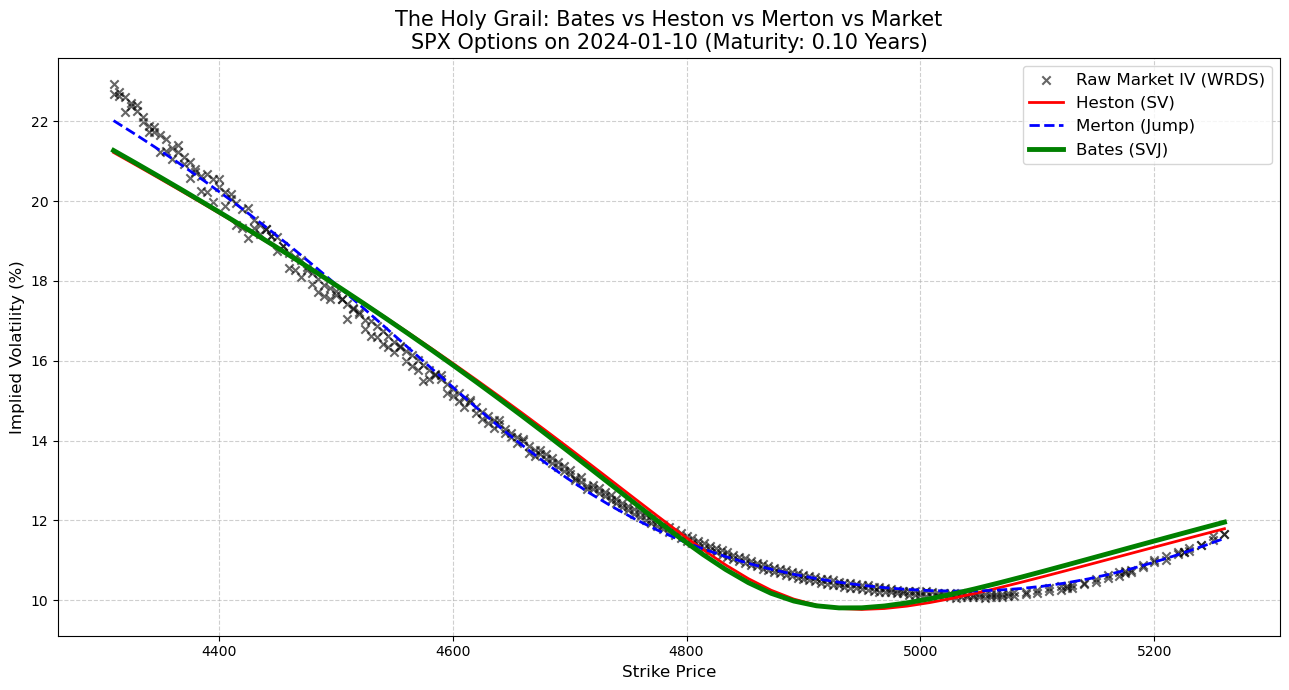

In [18]:
import numpy as np
import warnings
from scipy.integrate import quad, IntegrationWarning
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt

print("🚀 Starting Final Bates (SVJ) Calibration...")

# ==============================================================================
# 1. BATES PRICING MATH 
# ==============================================================================
def bates_characteristic_function(u, S0, K, T, r, q, v0, kappa, theta, xi, rho, lam, mu_j, delta):
    # --- A. Heston Continuous Volatility Component ---
    alpha = -u**2 / 2 - 1j * u / 2
    beta = kappa - rho * xi * 1j * u
    gamma = xi**2 / 2
    
    d = np.sqrt(beta**2 - 4 * alpha * gamma)
    r_plus = (beta + d) / (xi**2)
    r_minus = (beta - d) / (xi**2)
    g = r_minus / r_plus
    
    C = kappa * (r_minus * T - (2 / (xi**2)) * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
    D = r_minus * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))
    
    heston_cf = np.exp(C * theta + D * v0 + 1j * u * np.log(S0 * np.exp((r - q) * T)))
    
    # --- B. Merton Poisson Jump Component ---
    k = np.exp(mu_j + 0.5 * delta**2) - 1 # Expected jump size
    jump_term = np.exp(mu_j * 1j * u - 0.5 * delta**2 * u**2) - 1
    drift_compensator = -1j * u * k
    
    merton_cf = np.exp(lam * T * (jump_term + drift_compensator))
    
    # The beauty of independent processes: we just multiply their characteristic functions!
    return heston_cf * merton_cf

def bates_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho, lam, mu_j, delta):
    def integrand1(u):
        cf = bates_characteristic_function(u - 1j, S0, K, T, r, q, v0, kappa, theta, xi, rho, lam, mu_j, delta)
        num = np.exp(-1j * u * np.log(K)) * cf
        den = (1j * u * S0 * np.exp((r-q)*T))
        return (num / den).real

    def integrand2(u):
        cf = bates_characteristic_function(u, S0, K, T, r, q, v0, kappa, theta, xi, rho, lam, mu_j, delta)
        num = np.exp(-1j * u * np.log(K)) * cf
        den = (1j * u)
        return (num / den).real

    limit_max = 2000 # Keeping the Gibbs-fix so the line stays smooth
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", IntegrationWarning)
        P1_integral = quad(integrand1, 0, limit_max, epsabs=1e-4, epsrel=1e-4, limit=200)[0]
        P2_integral = quad(integrand2, 0, limit_max, epsabs=1e-4, epsrel=1e-4, limit=200)[0]
        
    P1 = 0.5 + (1 / np.pi) * P1_integral
    P2 = 0.5 + (1 / np.pi) * P2_integral
    
    call_price = S0 * np.exp(-q * T) * P1 - K * np.exp(-r * T) * P2
    return max(0.0, call_price)

# ==============================================================================
# 2. CALIBRATION 
# ==============================================================================
def bates_objective(params):
    v0, kappa, theta, xi, rho, lam, mu_j, delta = params
    error = 0.0
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, K in enumerate(valid_strikes):
            m_price = bates_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho, lam, mu_j, delta)
            m_iv = implied_volatility(m_price, S0, K, T, r, q)
            
            if np.isnan(m_iv):
                error += 5.0
            else:
                error += (m_iv - target_ivs[i])**2
                
    return error / len(valid_strikes)

# Parameter Seeding: We use your winning parameters from the last two runs!
bates_guess = [
    0.0115, 3.0293, 0.0684, 1.1963, -0.6572, # Your winning Heston params
    0.9923, -0.0825, 0.0779                  # Your winning Merton params
]

bates_bounds = [
    (0.005, 0.15),  # v0 
    (0.5, 5.0),     # kappa 
    (0.005, 0.15),  # theta 
    (0.05, 1.5),    # xi 
    (-0.95, -0.2),  # rho 
    (0.0, 3.0),     # lam 
    (-0.5, 0.0),    # mu_j 
    (0.01, 0.3)     # delta 
]

start_time = time.time()
res_bates = minimize(
    bates_objective,
    bates_guess,
    method='L-BFGS-B',
    bounds=bates_bounds,
    options={'ftol': 1e-7, 'maxiter': 100}
)
elapsed = round(time.time() - start_time, 2)

v0_b, kappa_b, theta_b, xi_b, rho_b, lam_b, mu_j_b, delta_b = res_bates.x

print(f"✅ Bates Calibration Complete in {elapsed}s!")
print("="*40)
print("🏆 OPTIMAL BATES (SVJ) PARAMETERS")
print("="*40)
print(f"v0    = {v0_b:.4f} | kappa = {kappa_b:.4f} | theta = {theta_b:.4f}")
print(f"xi    = {xi_b:.4f} | rho   = {rho_b:.4f}")
print(f"lam   = {lam_b:.4f} | mu_j  = {mu_j_b:.4f} | delta = {delta_b:.4f}")
print(f"Final IV Error (MSE): {res_bates.fun:.6f}")
print("="*40)

# ==============================================================================
# 3. THE MASTER PLOT 
# ==============================================================================
print("Generating the Ultimate Volatility Smile Plot...")

bates_prices = [bates_call_price(S0, k, T, r, q, *res_bates.x) for k in smooth_strikes]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bates_iv = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(bates_prices, smooth_strikes)]

valid_idx_b = ~np.isnan(bates_iv)
clean_strikes_b = np.array(smooth_strikes)[valid_idx_b]
clean_iv_b = np.array(bates_iv)[valid_idx_b] * 100

plt.figure(figsize=(13, 7))

# Market Data
plt.scatter(valid_strikes, target_ivs * 100, color='black', label='Raw Market IV (WRDS)', marker='x', alpha=0.6)

# The Three Models
plt.plot(clean_strikes, clean_iv, color='red', label=f'Heston (SV)', linewidth=2)
plt.plot(clean_strikes_m, clean_iv_m, color='blue', label=f'Merton (Jump)', linewidth=2, linestyle='--')
plt.plot(clean_strikes_b, clean_iv_b, color='green', label=f'Bates (SVJ)', linewidth=3.5)

plt.title(f"The Holy Grail: Bates vs Heston vs Merton vs Market\nSPX Options on {TARGET_DATE} (Maturity: {T:.2f} Years)", fontsize=15)
plt.xlabel("Strike Price", fontsize=12)
plt.ylabel("Implied Volatility (%)", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()